In [1]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import imblearn

In [2]:
def upsample_label(temp_x, temp_y):
    y_time_list = temp_y['time'].values
    y_label = temp_y['label'].values
    jdx = 0
    label_list = []
    for index,row in temp_x.iterrows():
        try:
            if row['time'] > y_time_list[jdx]:
                jdx+=1
            label_list.append(y_label[jdx])
        except:
            label_list.append(y_label[jdx - 1])
    return label_list

In [3]:
filepath = "TrainingData/"
column_list = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z','subject', 'time', 'label']
final_df = pd.DataFrame([], columns = column_list)
for i in glob.glob(filepath + '*.csv'):
    df_type = i.split('.')[0].split('__')[1]
    file_name = i.split('\\')[1].split('__')[0]
    if df_type == 'x':
        x = open(filepath + file_name + '__x.csv')
        x = pd.read_csv(x)
        x['subject'] = [file_name] * x.shape[0]
        
        x_time = open(filepath + file_name + '__x_time.csv')
        x_time = pd.read_csv(x_time)
        x['time'] = x_time
        
        y = open(filepath + file_name + '__y.csv')
        y = pd.read_csv(y)
        y['subject'] = [file_name] * y.shape[0]
        
        y_time = open(filepath + file_name + '__y_time.csv')
        y_time = pd.read_csv(y_time)
        y['time'] = y_time
        
        y.columns = ['label', 'subject', 'time']
        label_list = upsample_label(x, y)
        x['label'] = label_list
        x.columns = column_list
        final_df = pd.concat([final_df, x], ignore_index=True)

In [4]:
final_df.shape

(1341617, 9)

In [5]:
final_df.head(20)

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,subject,time,label
0,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,subject_001_01,0.025,0
1,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,subject_001_01,0.050,0
2,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,subject_001_01,0.075,0
3,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,subject_001_01,0.100,0
4,4.226515,8.273807,2.851742,0.012534,0.000445,-0.016830,subject_001_01,0.125,0
5,4.532063,8.398341,2.856682,0.014484,0.028769,-0.011091,subject_001_01,0.150,0
6,4.433669,8.294719,2.823521,0.016340,-0.029434,-0.008998,subject_001_01,0.175,0
7,4.160676,8.260676,2.827568,0.011222,-0.016748,-0.006027,subject_001_01,0.200,0
8,4.432763,8.272613,2.790050,-0.002715,0.023094,0.012222,subject_001_01,0.225,0
9,4.511362,8.256774,2.820538,-0.002248,0.001547,0.011137,subject_001_01,0.250,0


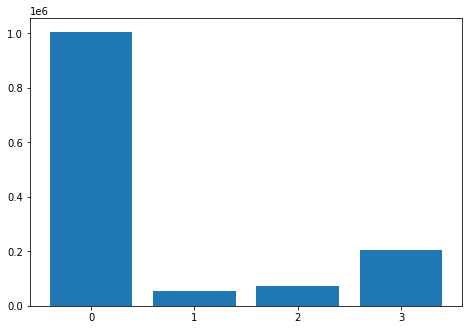

In [6]:
x_label = ['0', '1', '2', '3']
y_label = []
for i in range(4):
    y_label.append(final_df['label'].value_counts()[i])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_label, y_label)
plt.show()

In [48]:
from sklearn.model_selection import train_test_split
df_X = final_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
df_Y = final_df[['label']]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)

In [49]:
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Conv1D, Dropout, BatchNormalization, MaxPooling1D, UpSampling1D

In [50]:
dropout_rate = 0.1
input_layer = Input([40, 6])

conv1 = Conv1D(filters=16, kernel_size=2, padding="same", activation = "relu")(input_layer)
conv1 = Dropout(dropout_rate)(conv1)
conv1 = MaxPooling1D(pool_size =2)(conv1)

conv2 = Conv1D(filters=32, kernel_size=2, padding="same", activation = "relu")(conv1)
conv2 = Dropout(dropout_rate)(conv2)
conv2 = MaxPooling1D(pool_size =2)(conv2)

conv3 = Conv1D(filters=64, kernel_size=2, padding="same", activation = "relu")(conv2)
conv3 = Dropout(dropout_rate)(conv3)
conv3 = MaxPooling1D(pool_size =2)(conv3)

deconv3 = Conv1D(filters=64, kernel_size=2, padding = "same", activation="relu")(conv3)
deconv3 = Dropout(dropout_rate)(deconv3)
deconv3 = UpSampling1D(size =2)(deconv3)

deconv2 = Conv1D(filters=32, kernel_size=2, padding = "same", activation="relu")(deconv3)
deconv2 = Dropout(dropout_rate)(deconv2)
deconv2 = UpSampling1D(size =2)(deconv2)

deconv1 = Conv1D(filters=16, kernel_size=2, padding = "same", activation="relu")(deconv2)
deconv1 = Dropout(dropout_rate)(deconv1)
deconv1 = UpSampling1D(size =2)(deconv1)

output_layer = Conv1D(filters = 4, kernel_size = 2, padding = "same", activation="softmax")(deconv1)


temp_model = Model(inputs=input_layer, outputs=output_layer)

In [51]:
def make_windows(arr, win_size, step_size):
    w_list = list()
    n_records = arr.shape[0]
    remainder = (n_records - win_size) % step_size 
    num_windows = 1 + int((n_records - win_size - remainder) / step_size)
    for k in range(num_windows):
        w_list.append(arr[k*step_size:win_size-1+k*step_size+1])
    return np.array(w_list)

In [52]:
import tensorflow as tf

# custom weighted loss function (weighted categorical cross entropy)
def weighted_crossentropy(y_true, y_pred):
    EPSILON = 0.0001

    y_t = tf.math.multiply(tf.broadcast_to(tf.constant([2, 1, 1, 2], dtype = float), tf.shape(y_true)) , y_true)
    h_t = tf.math.multiply(tf.broadcast_to(tf.constant([1, 1, 1, 1], dtype = float), tf.shape(y_pred)) , y_pred)

    return tf.math.reduce_mean(- tf.math.multiply(y_t  , tf.math.log(tf.add(h_t, EPSILON))))

In [53]:
import keras
from tensorflow.keras.utils import to_categorical

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

y_train = to_categorical(y_train)
X_train = make_windows(X_train, 40, 5)
y_train = make_windows(y_train, 40, 5)

temp_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=weighted_crossentropy,
    metrics=["accuracy"],    
  )

history = temp_model.fit(X_train, y_train, epochs = 200 , batch_size = 128)

temp_model.evaluate(X_train, y_train)
temp_model.evaluate(X_test, y_test)


Epoch 1/200
1677/1677 [==============================] - 16s 9ms/step - loss: 0.3213 - accuracy: 0.7501
Epoch 2/200
1677/1677 [==============================] - 15s 9ms/step - loss: 0.3174 - accuracy: 0.7505
Epoch 3/200
1677/1677 [==============================] - 15s 9ms/step - loss: 0.3165 - accuracy: 0.7505
Epoch 4/200
1677/1677 [==============================] - 15s 9ms/step - loss: 0.3159 - accuracy: 0.7505
Epoch 5/200
1677/1677 [==============================] - 15s 9ms/step - loss: 0.3153 - accuracy: 0.7506
Epoch 6/200
1677/1677 [==============================] - 15s 9ms/step - loss: 0.3147 - accuracy: 0.7507
Epoch 7/200
1677/1677 [==============================] - 15s 9ms/step - loss: 0.3141 - accuracy: 0.7510
Epoch 8/200
1677/1677 [==============================] - 15s 9ms/step - loss: 0.3136 - accuracy: 0.7512
Epoch 9/200
1677/1677 [==============================] - 15s 9ms/step - loss: 0.3132 - accuracy: 0.7514
Epoch 10/200
1677/1677 [==============================] - 15s 9m

KeyboardInterrupt: 